
# Deep Learning: identify painter from painting

**Gabriele Omari**

**Statistical Machine Learning**

**19/02/2020**

## Prepare the analysis

Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

******

Import modules

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from skimage import io
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

*******

Set path to data

In [0]:
path=os.path.join(os.getcwd(),"drive","My Drive","Progetto SML","images")

*******

## Show details about some painters

In [0]:
dfArtists=pd.read_csv(os.path.join(os.getcwd(),"drive","My Drive","Progetto SML","artists.csv"))
dfArtists1=dfArtists.drop(["id","bio","wikipedia"],1)
dfArtists1.head(n=10)


name        years  ... nationality paintings
0   Amedeo Modigliani  1884 - 1920  ...     Italian       193
1  Vasiliy Kandinskiy  1866 - 1944  ...     Russian        88
2        Diego Rivera  1886 - 1957  ...     Mexican        70
3        Claude Monet  1840 - 1926  ...      French        73
4       Rene Magritte  1898 - 1967  ...     Belgian       194
5       Salvador Dali  1904 - 1989  ...     Spanish       139
6       Edouard Manet  1832 - 1883  ...      French        90
7       Andrei Rublev  1360 - 1430  ...     Russian        99
8    Vincent van Gogh  1853 – 1890  ...       Dutch       877
9        Gustav Klimt  1862 - 1918  ...    Austrian       117

[10 rows x 5 columns]

******

## Visualize some paintings

Create ImageDataBunch in fast.ai

In [0]:
np.random.seed(42)
Data = ImageDataBunch.from_folder(path,
                                  train="images",
                                  #test="Valid",
                                  valid_pct=0.1,
                                  size=(3,331,331),
                                  #ds_tfms=get_transforms(),
                                  bs=32,
                                  num_workers=4).normalize(imagenet_stats)
Data                   

ImageDataBunch;

Train: LabelList (7602 items)
x: ImageList
Image (3, 331, 331),Image (3, 331, 331),Image (3, 331, 331),Image (3, 331, 331),Image (3, 331, 331)
y: CategoryList
Diego_Velazquez,Diego_Velazquez,Diego_Velazquez,Diego_Velazquez,Diego_Velazquez
Path: /content/drive/My Drive/Progetto SML/images;

Valid: LabelList (844 items)
x: ImageList
Image (3, 331, 331),Image (3, 331, 331),Image (3, 331, 331),Image (3, 331, 331),Image (3, 331, 331)
y: CategoryList
Rene_Magritte,Jan_van_Eyck,Kazimir_Malevich,Rene_Magritte,Marc_Chagall
Path: /content/drive/My Drive/Progetto SML/images;

Test: None

Visualize data

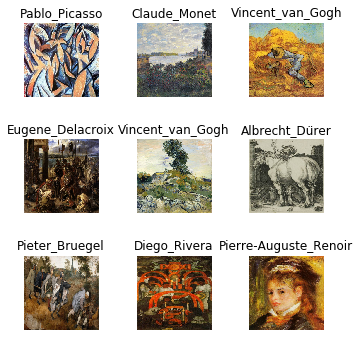

In [0]:
Data.show_batch(rows=3, figsize=(5,5))

******


## DenseNet201 Model

### Tune hyperparameters

Setting wd=1e-2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-03
Min loss divided by 10: 3.98E-03


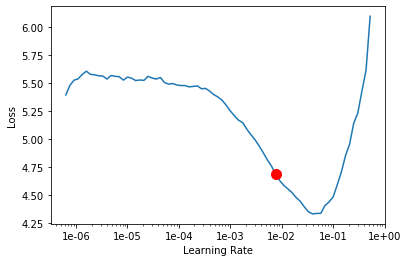

In [0]:
densenetModel = cnn_learner(Data,
                      base_arch=models.densenet201,
                      metrics=[accuracy,top_k_accuracy])
densenetModel.lr_find(wd=1e-2)
densenetModel.recorder.plot(suggestion=True)

Setting wd=1e-4

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/checkpoints/densenet201-c1103571.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03
Min loss divided by 10: 3.98E-03


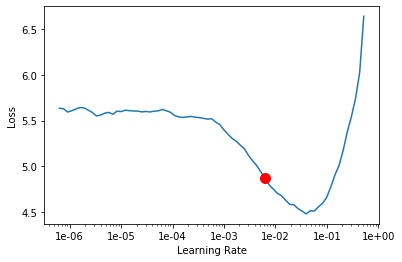

In [0]:
densenetModel = cnn_learner(Data,
                      base_arch=models.densenet201,
                      metrics=[accuracy,top_k_accuracy])
densenetModel.lr_find(wd=1e-4)
densenetModel.recorder.plot(suggestion=True)

In [0]:
densenetModel.recorder.min_grad_lr

0.006309573444801929

Setting wd=1e-6

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03
Min loss divided by 10: 3.98E-03


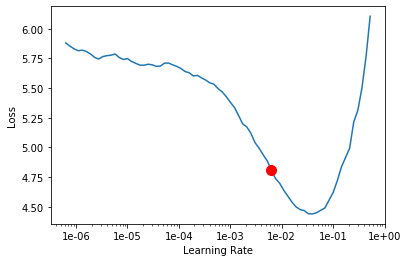

In [0]:
densenetModel = cnn_learner(Data,
                      base_arch=models.densenet201,
                      metrics=[accuracy,top_k_accuracy])
densenetModel.lr_find(wd=1e-6)
densenetModel.recorder.plot(suggestion=True)

*********

### Train and Validate the model

In [0]:
densenetModel.fit_one_cycle( cyc_len=10,
                            max_lr=slice(6.31e-3),
                            wd=1e-6)

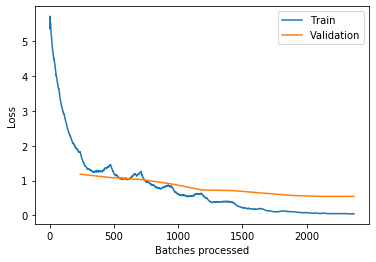

In [0]:
densenetModel.recorder.plot_losses()

In [0]:
densenetModel.validate()

[0.54755384, tensor(0.8661), tensor(0.9739)]

In [0]:
densenetModel.show_results()

Output hidden; open in https://colab.research.google.com to view.

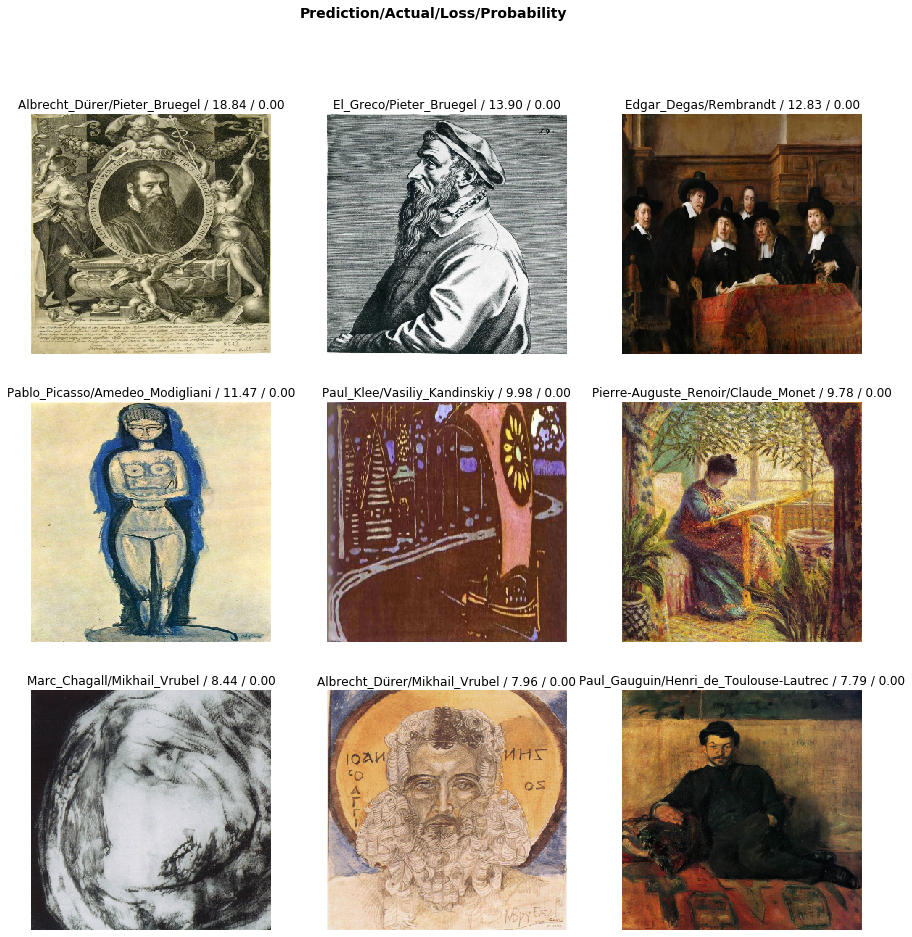

In [0]:
densenetInterp = ClassificationInterpretation.from_learner(densenetModel)
#densenetInterp.plot_confusion_matrix()
densenetInterp.plot_top_losses(9, figsize=(15,15))

In [0]:
densenetModel.save(os.path.join(os.getcwd(),"drive","My Drive","Progetto SML","densenetModel_wd1e-6"))

*******

### Unfreeze the model

In [0]:
densenetModel1=densenetModel

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 6.31E-08


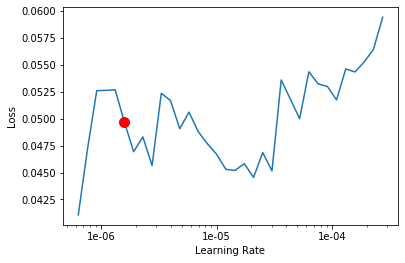

In [0]:
densenetModel1.unfreeze()
densenetModel1.lr_find(wd=1e-6)
densenetModel1.recorder.plot(suggestion=True)

In [0]:
densenetModel1.recorder.min_grad_lr

1.5848931924611132e-06

In [0]:
densenetModel1.fit_one_cycle(cyc_len=5,
                            max_lr=slice(1.58e-7,1.58e-6),
                            wd=1e-6)

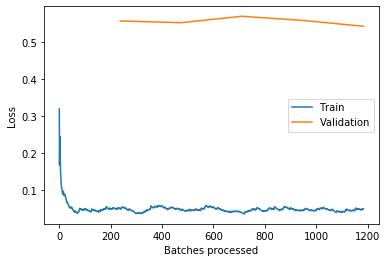

In [0]:
densenetModel1.recorder.plot_losses()

In [0]:
densenetModel1.validate()

[0.54283977, tensor(0.8649), tensor(0.9751)]

In [0]:
densenetModel1.show_results()

Output hidden; open in https://colab.research.google.com to view.

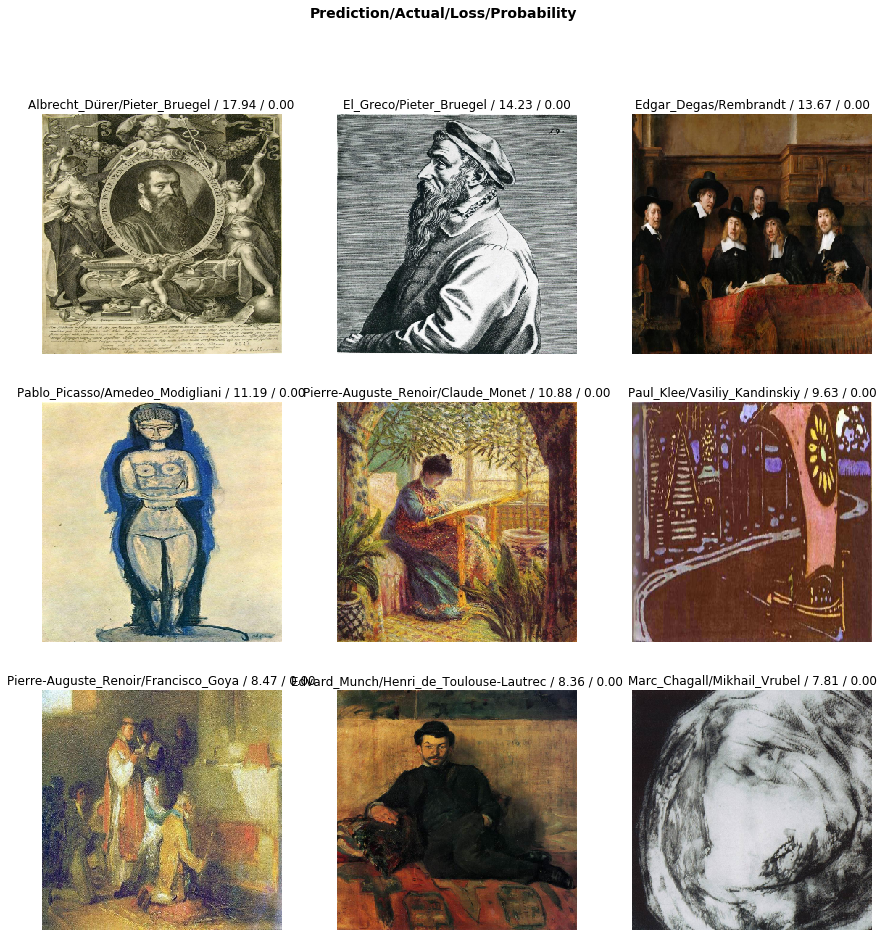

In [0]:
densenet1Interp = ClassificationInterpretation.from_learner(densenetModel1)
#densenetInterp.plot_confusion_matrix()
densenet1Interp.plot_top_losses(9, figsize=(15,15))

In [0]:
densenetModel1.save(os.path.join(os.getcwd(),"drive","My Drive","Progetto SML","densenetModel1_wd1e-6"))

************

## Resnet152 Model

### Tune hyperparameters

Set wd=1e-2

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03
Min loss divided by 10: 4.79E-03


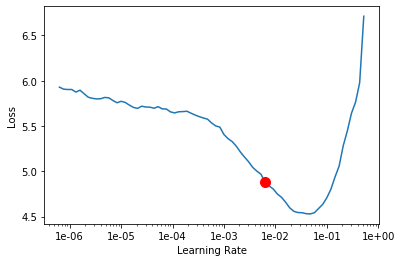

In [0]:
resnetModel = cnn_learner(Data,
                      base_arch=models.resnet152,
                      metrics=[accuracy,top_k_accuracy])
resnetModel.lr_find(wd=1e-2)
resnetModel.recorder.plot(suggestion=True)

Set wd=1e-4

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03
Min loss divided by 10: 4.79E-03


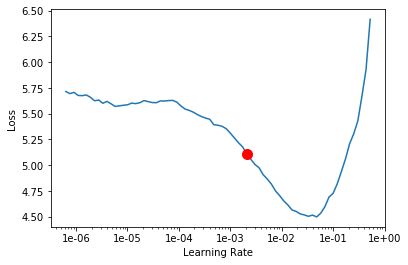

In [0]:
resnetModel = cnn_learner(Data,
                      base_arch=models.resnet152,
                      metrics=[accuracy,top_k_accuracy])
resnetModel.lr_find(wd=1e-4)
resnetModel.recorder.plot(suggestion=True)

In [0]:
resnetModel.recorder.min_grad_lr

0.0020892961308540407

Set wd=1e-6

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-03
Min loss divided by 10: 3.31E-03


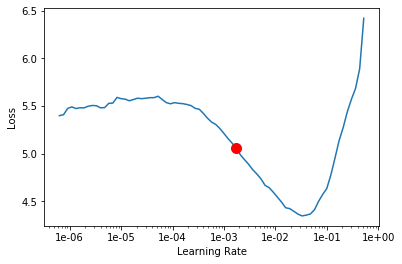

In [0]:
resnetModel = cnn_learner(Data,
                      base_arch=models.resnet152,
                      metrics=[accuracy,top_k_accuracy])
resnetModel.lr_find(wd=1e-6)
resnetModel.recorder.plot(suggestion=True)

*********

### Train and Validate the model

In [0]:
resnetModel = cnn_learner(Data,
                      base_arch=models.resnet152,
                      metrics=[accuracy,top_k_accuracy])
resnetModel.fit_one_cycle(cyc_len=10,
                            max_lr=slice(2.09e-3),
                            wd=1e-4)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


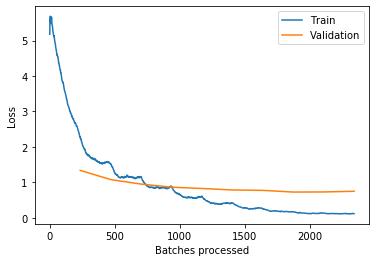

In [0]:
resnetModel.recorder.plot_losses()

In [0]:
resnetModel.validate()

[0.7490123, tensor(0.8213), tensor(0.9544)]

In [0]:
resnetModel.show_results()

Output hidden; open in https://colab.research.google.com to view.

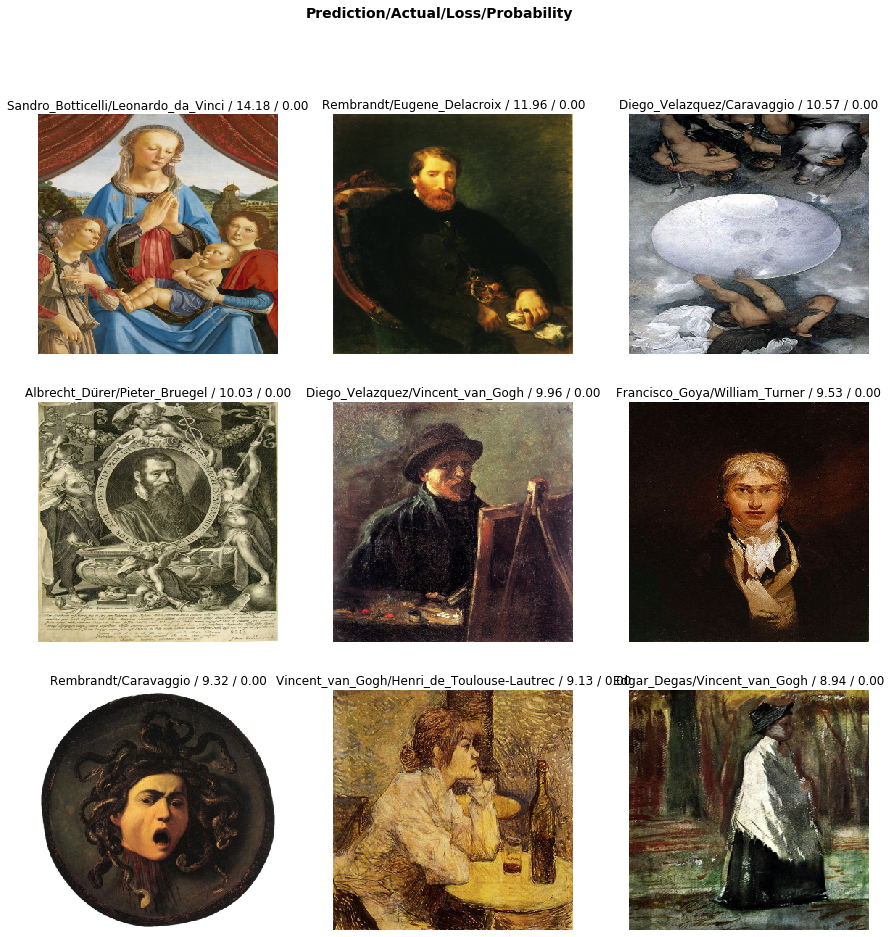

In [0]:
resnetInterp = ClassificationInterpretation.from_learner(resnetModel)
#densenetInterp.plot_confusion_matrix()
resnetInterp.plot_top_losses(9, figsize=(15,15))

In [0]:
resnetModel.save(os.path.join(os.getcwd(),"drive","My Drive","Progetto SML","resnetModel"))

******

### Unfreeze the model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 1.20E-06


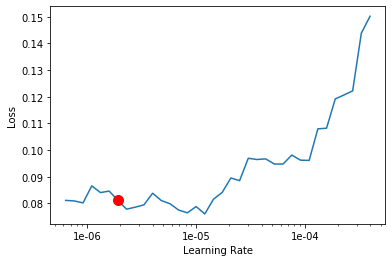

In [0]:
resnetModel1=resnetModel
resnetModel1.unfreeze()
resnetModel1.lr_find(wd=1e-4)
resnetModel1.recorder.plot(suggestion=True)

In [0]:
resnetModel1.recorder.min_grad_lr

1.9054607179632473e-06

In [0]:
resnetModel1.fit_one_cycle(cyc_len=5,
                          max_lr=slice(1.91e-7,1.91e-6),
                          wd=1e-4)

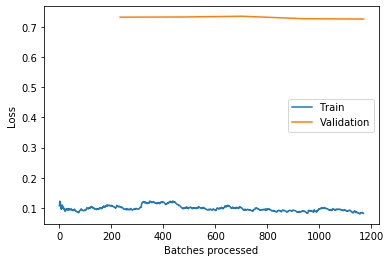

In [0]:
resnetModel1.recorder.plot_losses()

In [0]:
resnetModel1.validate()

[0.7267889, tensor(0.8237), tensor(0.9556)]

In [0]:
resnetModel1.show_results()

Output hidden; open in https://colab.research.google.com to view.

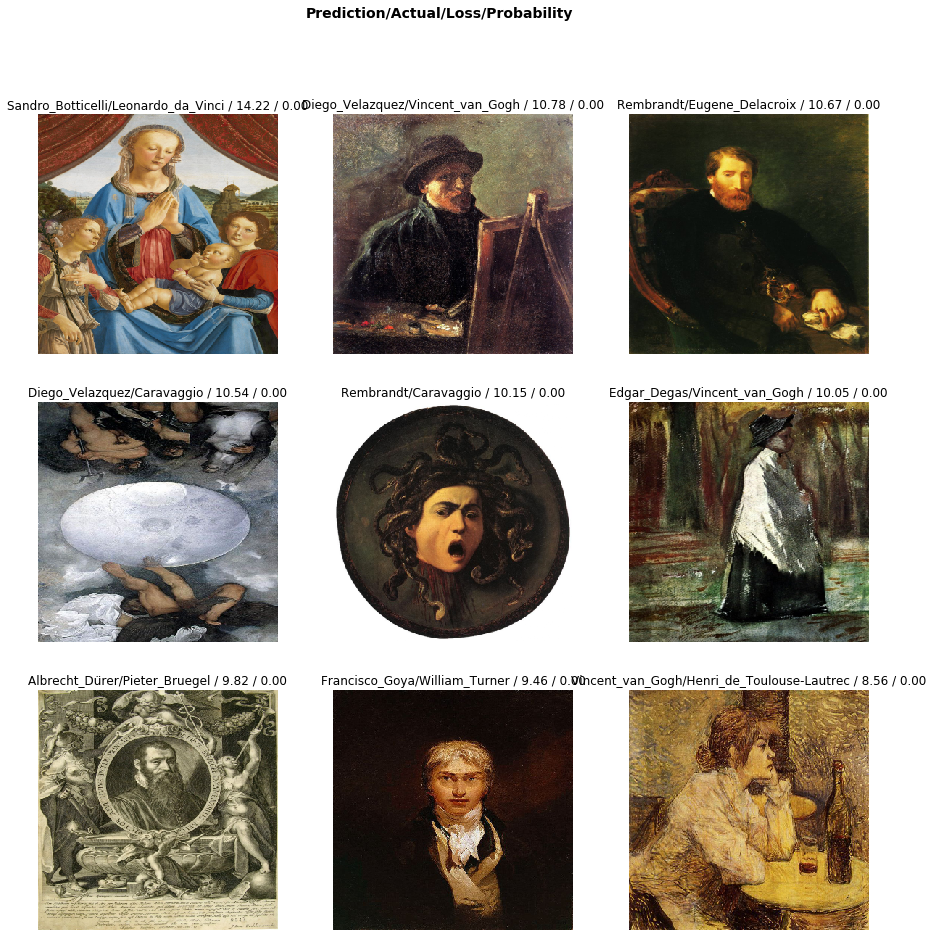

In [0]:
resnet1Interp = ClassificationInterpretation.from_learner(resnetModel1)
#densenetInterp.plot_confusion_matrix()
resnet1Interp.plot_top_losses(9, figsize=(15,15))

In [0]:
resnetModel1.save(os.path.join(os.getcwd(),"drive","My Drive","Progetto SML","resnetModel1"))

******

## References

* [best-artworks-of-all-time](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)
(I have just removed from my "Train Data" folder one of the two subfolders relative to Albrecht Dürer)
*  [fast.ai](https://www.fast.ai) 


## Bibliography

*   [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)
*   [Densely Connected Convolutional Networks](https://arxiv.org/pdf/1608.06993.pdf)



